In [16]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data1 = pd.read_csv('../data/Data.csv')
labels1 = pd.read_csv('../data/Label.csv')

combined_data = pd.concat([data1, labels1], axis=1)

# Filter rows where 'Label' is 0
filtered_data = combined_data[combined_data['Label'] > 0]

# Extract filtered data and labels
filtered_data_only = filtered_data.drop(columns=['Label'])
filtered_labels_only = filtered_data['Label']

print("Filtered data shape:", filtered_data_only.shape)
print("Filtered labels shape:", filtered_labels_only.shape)
X_train1, X_test1, y_train1, y_test1 = train_test_split(filtered_data_only, filtered_labels_only, test_size=0.2,
                                                        random_state=42)
print("Training data shape:", X_train1.shape, y_train1.shape)
print("Testing data shape:", X_test1.shape, y_test1.shape)
y_train1 = y_train1 - 1
y_test1 = y_test1 - 1
print(np.unique(y_train1))
print(np.unique(y_test1))
print(filtered_labels_only.nunique())

Filtered data shape: (89583, 76)
Filtered labels shape: (89583,)
Training data shape: (71666, 76) (71666,)
Testing data shape: (17917, 76) (17917,)
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
9


In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

In [18]:
pca = PCA()  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

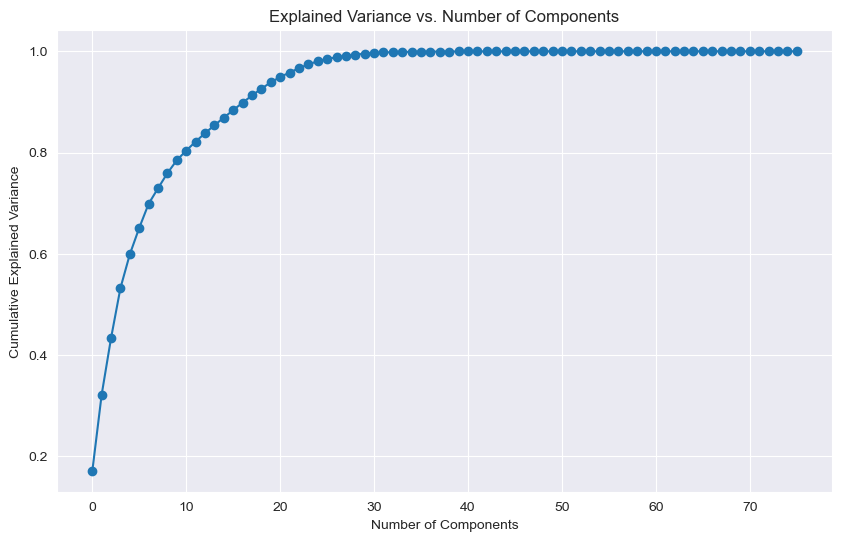

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [20]:
pca_95 = PCA(n_components=0.95)  # Keep enough components to explain 95% of variance
X_train_pca_95 = pca_95.fit_transform(X_train_scaled)
X_test_pca_95 = pca_95.transform(X_test_scaled)

PCA Component Loadings:
     Flow Duration  Total Fwd Packet  Total Bwd packets  \
PC1       0.202807          0.114301           0.094703   
PC2      -0.034874          0.175850           0.158853   
PC3      -0.065486         -0.184236          -0.108791   
PC4      -0.016840         -0.094031          -0.092614   
PC5       0.024608         -0.155765           0.248738   

     Total Length of Fwd Packet  Total Length of Bwd Packet  \
PC1                    0.105299                    0.070083   
PC2                    0.163701                    0.121501   
PC3                   -0.179092                   -0.072584   
PC4                   -0.086781                   -0.074106   
PC5                   -0.186612                    0.301653   

     Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
PC1               0.061783              -0.000680                0.059908   
PC2               0.132127              -0.016589                0.124077   
PC3        

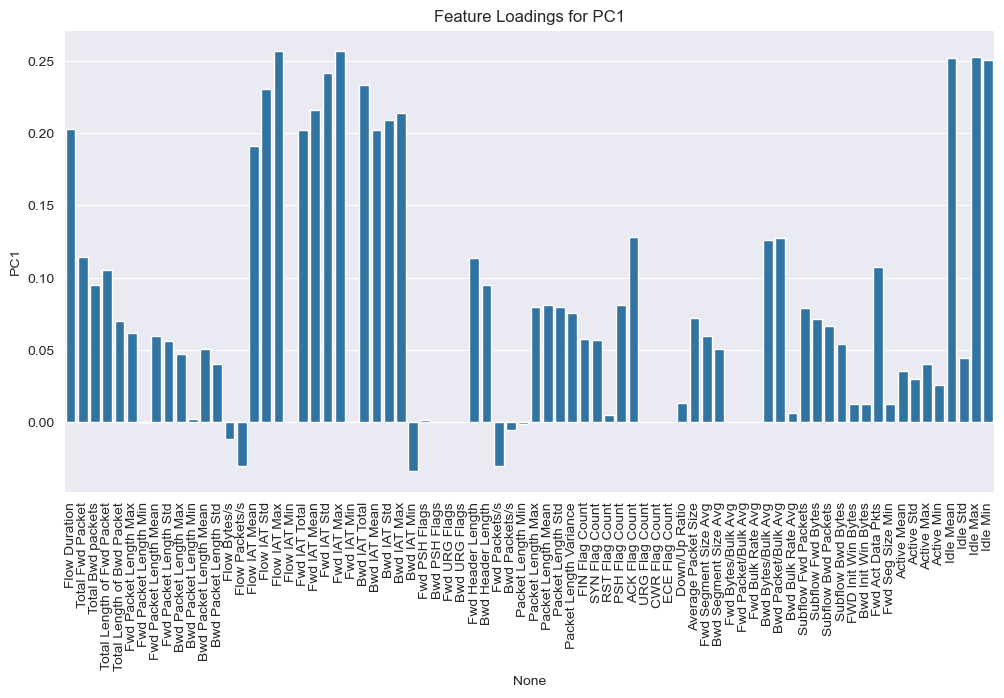

In [32]:
pca_components = pd.DataFrame(
    pca_95.components_,
    columns=filtered_data_only.columns,  # Use original feature names as columns
    index=[f'PC{i+1}' for i in range(pca_95.n_components_)]
)

# Display the first few components with their feature loadings
print("PCA Component Loadings:")
print(pca_components.head())

# Optionally, plot the loadings for a specific component (e.g., PC1)
plt.figure(figsize=(12, 6))
sns.barplot(x=pca_components.columns, y=pca_components.loc['PC1'])
plt.xticks(rotation=90)
plt.title('Feature Loadings for PC1')
plt.show()

In [21]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_pca_95, y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
y_pred1 = xgb_classifier.predict(X_test_pca_95)

In [23]:
print("\nClassification Report:")
report = classification_report(y_test1, y_pred1, target_names=[f"Class {i}" for i in np.unique(y_test1)])
print(report)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.35      0.28      0.31        68
     Class 1       0.52      0.18      0.27        77
     Class 2       0.66      0.13      0.22       917
     Class 3       0.75      0.75      0.75      6191
     Class 4       0.65      0.92      0.76      5859
     Class 5       0.82      0.53      0.65       929
     Class 6       0.88      0.65      0.75      3370
     Class 7       0.51      0.17      0.25       457
     Class 8       0.45      0.18      0.26        49

    accuracy                           0.72     17917
   macro avg       0.62      0.42      0.47     17917
weighted avg       0.73      0.72      0.70     17917



using random forest

In [24]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_pca_95, y_train1)

RandomForestClassifier(random_state=42)

In [29]:
y_pred = rf_classifier.predict(X_test_pca_95)


In [30]:
print("\nClassification Report:")
report = classification_report(y_test1, y_pred, target_names=[f"Class {i}" for i in np.unique(y_test1)])
print(report)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.42      0.32      0.36        68
     Class 1       0.59      0.25      0.35        77
     Class 2       0.49      0.23      0.31       917
     Class 3       0.72      0.76      0.74      6191
     Class 4       0.69      0.81      0.75      5859
     Class 5       0.81      0.58      0.68       929
     Class 6       0.74      0.68      0.71      3370
     Class 7       0.42      0.23      0.29       457
     Class 8       0.26      0.14      0.18        49

    accuracy                           0.71     17917
   macro avg       0.57      0.44      0.49     17917
weighted avg       0.70      0.71      0.70     17917

